### BoolODE data for this experiment can be downloaded from the following link
Data download: https://huggingface.co/datasets/lazaratan/sf2m-grn-boolode-data/blob/main/sf2m-grn-data.zip

In [1]:
import pandas as pd
import numpy as np
import scprep
from sklearn.metrics import roc_auc_score, average_precision_score
import os
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from copy import deepcopy

In [2]:
def plot(simdir):
    
    simulation_dir = os.path.join(simdir, "simulations")
    n_cells = len([s for s in os.listdir(simulation_dir) if s.endswith(".csv")])
    dfs = [0] * n_cells
    for f in os.listdir(simulation_dir):
        if not f.endswith("csv"):
            continue
        i = int(f.split(".")[0][1:])
        dfs[i] = pd.read_csv(os.path.join(simulation_dir, f), index_col=0)
    ref_net = pd.read_csv(os.path.join(simdir, "refNetwork.csv"))
    n_genes = dfs[0].shape[0]
    genes = [f"g{i+1}" for i in range(n_genes)]

    data = []
    for df in dfs:
        data.append(df.values)
    data = np.array(data)

    #print(data.shape)
    data = np.swapaxes(data, 1, 2)
    
    # cells x time x genes
    data = data[:, ::9, :]
    data = data[:, 1:, :]


    A = np.zeros((n_genes, n_genes))
    for i, row in ref_net.iterrows():
        gene1 = int(row["Gene1"][1:]) # - 1 if gene names don't start at zero
        gene2 = int(row["Gene2"][1:]) # - 1 if gene names don't start at zero
        rel = 1 if row["Type"] == "+" else -1
        A[gene1, gene2] = rel

    return data, np.abs(A)

In [3]:
datas_train, datas_val = [], []
graphs_train, graphs_val = [], []
actions_train, actions_val = [], []
train_val_split = [0.8, 0.2]
for path in os.listdir("Synthetic-I"):
    p = os.path.join("Synthetic-I", path)
    #if 'I-3' not in p:
    #    continue
    if 'TF' in p or 'I-2' in p or 'I-3' in p or 'large' in p or 'gnull' not in p:
        continue
    #if 'BF-I-large' not in p:
    #    continue
    else:
        print(p)
        data, graph = plot(p)
        train_len = int(data.shape[0]*train_val_split[0])
        val_len = int(data.shape[0]*train_val_split[1])
        print(data.shape, train_len, val_len)
        action = np.ones((data.shape[0], data.shape[-1]))
        if 'null' in p:
            print("No intervention")
            actions_train.append(action[:train_len])
            actions_val.append(action[train_len:])
        else:
            if 'I-3' not in p:
                a = int(list(filter(str.isdigit, p))[0])
            else:
                a = int(list(filter(str.isdigit, p))[1])
            print("Knock-out intervention on g%d" % a)
            action[:, a] = 0
            actions_train.append(action[:train_len])
            actions_val.append(action[train_len:])
        graphs_train.append(graph)
        graphs_val.append(graph)
        datas_train.append(data[:train_len])
        datas_val.append(data[train_len:])
print("Example boolODE data:", datas_train[0].shape, datas_val[0].shape)
true_graph = graphs_val[0]

Synthetic-I/dyn-BF-I-gnull


(1000, 55, 7) 800 200
No intervention
Example boolODE data: (800, 55, 7) (200, 55, 7)


<class 'networkx.classes.digraph.DiGraph'>


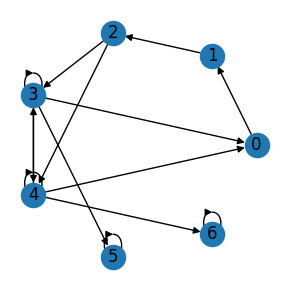

In [4]:
# plot GRN (causal graph)

import networkx as nx
fig, ax = plt.subplots(1,1, figsize=(3,3))
G = nx.from_numpy_array(graph, create_using=nx.DiGraph)
print(type(G))
nx.draw(G, ax=ax, pos=nx.circular_layout(G), arrows=True, with_labels=True)
plt.tight_layout()

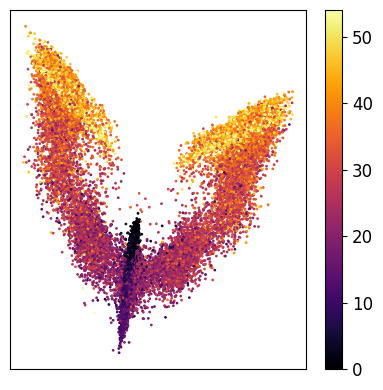

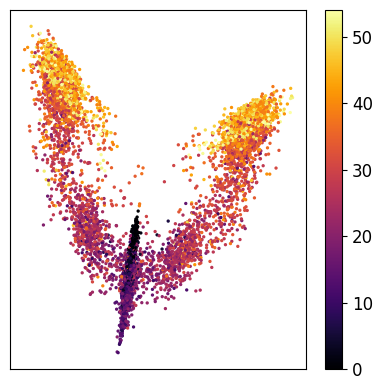

In [5]:
from sklearn.decomposition import PCA
fig, ax = plt.subplots(1,1, figsize=(4,4))
pca = PCA(n_components=2)
cells_null = datas_train[0].reshape(-1, datas_train[0].shape[-1])
pca_embed = pca.fit_transform(cells_null)
for data, graph in zip(datas_train, graphs_train):
    cells = data.reshape(-1, data.shape[-1])
    pca_embed = pca.transform(cells)
    labels = np.repeat(np.arange(data.shape[1])[None,:], data.shape[0], axis=0).flatten()
    scprep.plot.scatter2d(pca_embed, c=labels, ax=ax, ticks=False, colorbar=True)
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(4,4))
pca = PCA(n_components=2)
cells_null = datas_val[0].reshape(-1, datas_val[0].shape[-1])
pca_embed = pca.fit_transform(cells_null)
for data, graph in zip(datas_val, graphs_val):
    cells = data.reshape(-1, data.shape[-1])
    pca_embed = pca.transform(cells)
    labels = np.repeat(np.arange(data.shape[1])[None,:], data.shape[0], axis=0).flatten()
    scprep.plot.scatter2d(pca_embed, c=labels, ax=ax, ticks=False, colorbar=True)
plt.tight_layout()

In [6]:
import math

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torch.nn.functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x):
        x = x.requires_grad_(True)
        grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
        return grad[:, :-1]


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [8]:
sigma_min = 0.01

def sigmat(t):
    return torch.ones_like(t) * sigma_min
    

def F(t):
    t = t * 1.0
    if isinstance(t, float):
        t = torch.tensor(t)
    return t * sigma_min**2

class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, time_varying=False, reverse=False):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.time_varying = time_varying
        self.reverse = reverse

    # Drift
    def f(self, t, y):
        if self.reverse:
            t = 1 - t
        if len(t.shape) == len(y.shape):
            if self.time_varying:
                x = torch.cat([y, t], 1)
            else:
                x = y
        else:
            if self.time_varying:
                x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
            else: 
                x = y
        if self.reverse:
            return -self.drift(x) + self.score(x)
        return self.drift(x) + self.score(x)

    # Diffusion
    def g(self, t, y):
        return sigmat(t) * torch.ones_like(y)

In [13]:
import sys
from pathlib import Path

# Go up from notebook dir to project root (i.e., where 'runner' is)
curr = Path.cwd()
while not (curr / 'runner').exists() and curr != curr.parent:
    curr = curr.parent

# Add the project root to sys.path
sys.path.append(str(curr))

from runner.src.models.components import distribution_distances as dd 

In [14]:
def plot_pca_manifold(data, preds, ax, a=None):
    cells = data.reshape(-1, data.shape[-1])
    pca = PCA(n_components=2)
    pca_embed = pca.fit_transform(cells)
    pca_xT = pca.transform(preds)
    cells_end_points = np.stack([preds], axis=1)
    pca_cell_end_points = np.stack([pca_xT], axis=1)
    pca_cell_end_points = pca_cell_end_points.reshape(-1, pca_cell_end_points.shape[-1])
    labels = np.repeat(np.arange(data.shape[1])[None,:], data.shape[0], axis=0).flatten()
    scprep.plot.scatter2d(pca_embed, c=labels, ax=ax, ticks=False, colorbar=True)
    if a is None:
        labels_end_points = np.repeat(np.arange(cells_end_points.shape[1])[None,:], cells_end_points.shape[0], axis=0).flatten()
        scprep.plot.scatter2d(pca_cell_end_points, c=labels_end_points, ax=ax, ticks=False, colorbar=True)
    else:
        a = a.detach().cpu().numpy()
        group = []
        group_dict = {'control': [], 'g3': [], 'g4': []}
        data_dict = {'control': [], 'g3': [], 'g4': []}
        for i in range(a.shape[0]):
            not_control = (a[i].sum() < len(a[i]))
            if not_control == False:
                group.append(50)
                group_dict['control'].append('cyan')
                data_dict['control'].append(pca_cell_end_points[i])
            else:
                a_label = np.where(a[i] == 0)[0]
                #group.append(int(a_label) + 1)
                group.append(int(a_label))
                group_dict['g'+str(int(a_label))].append('red' if int(a_label) == 3 else 'blue')
                data_dict['g'+str(int(a_label))].append(pca_cell_end_points[i])
        for k, v in group_dict.items():
            if len(v) > 0:
                #scprep.plot.scatter2d(pca_cell_end_points, c=v, label=k, ax=ax, ticks=False, colorbar=True)
                scprep.plot.scatter2d(np.array(data_dict[k]), c=v, label=k, ax=ax, ticks=False, colorbar=True)
    plt.tight_layout()
    return pca

In [15]:
# Create causal layer model (inspired from DynGFN)
import torch.nn as nn
from typing import List

class LocallyConnected(nn.Module):
    """Local linear layer, i.e. Conv1dLocal() with filter size 1.

    Args:
        num_linear: num of local linear layers, i.e.
        in_features: m1
        out_features: m2
        bias: whether to include bias or not

    Shape:
        - Input: [n, d, m1]
        - Output: [n, d, m2]

    Attributes:
        weight: [d, m1, m2]
        bias: [d, m2]
    """

    def __init__(self, num_linear, input_features, output_features, time_varying=False, bias=True):
        super().__init__()
        self.num_linear = num_linear
        self.input_features = input_features
        self.output_features = output_features

        self.weight = nn.Parameter(
            torch.Tensor(self.num_linear, self.input_features, self.output_features)
        )
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.num_linear, self.output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter("bias", None)

        self.reset_parameters()

    @torch.no_grad()
    def reset_parameters(self):
        k = 1.0 / self.input_features
        bound = math.sqrt(k)
        nn.init.uniform_(self.weight, -bound, bound)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor):
        # [n, d, 1, m2] = [n, d, 1, m1] @ [1, d, m1, m2]
        #print(input.unsqueeze(dim=2).shape, self.weight.unsqueeze(dim=0).shape)
        out = torch.matmul(input.unsqueeze(dim=2), self.weight.unsqueeze(dim=0))
        out = out.squeeze(dim=2)
        if self.bias is not None:
            # [n, d, m2] += [d, m2]
            out += self.bias
        return out

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return "num_linear={}, in_features={}, out_features={}, bias={}".format(
            self.num_linear,
            self.input_features,
            self.output_features,
            self.bias is not None,
        )
    

class Intervenable(nn.Module):
    """Models implementing intervenable are useful for learning in the experimental setting.

    This should represent interventions on a preexisting set of possible targets.
    """

    def __init__(self, targets=None):
        super().__init__()
        self.targets = targets
        self.current_target = None

    # def do(self, target, value=0.0):
    #    raise NotImplementedError

    def get_linear_structure(self):
        """gets the linear approximation of the structure coefficients.

        May not be applicable for all models
        """
        raise NotImplementedError

    def get_structure(self) -> np.ndarray:
        """Extracts a single summary structure from the model."""
        raise NotImplementedError

    def get_structures(self, n_structures: int) -> np.ndarray:
        """Some models can provide empirical distributions over structures, this function samples a
        number of structures from the model."""
        raise NotImplementedError

    def set_target(self, target):
        if self.targets is not None and not np.isin(target, self.targets):
            raise ValueError("Bad Target selected {target}")
        self.current_target = target

    def l1_reg(self):
        raise NotImplementedError

    def l2_reg(self):
        raise NotImplementedError


class NGM(Intervenable):
    """Neural Graphical Model foudnation. """
    def __init__(self, dims, GL_reg=0.01, bias=True, time_varying=True):
        # dims: [number of variables, dimension hidden layers, output dim=1]
        super().__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1

        self.dims = dims
        self.time_varying = time_varying
        self.GL_reg = GL_reg  # adaptive lasso parameter

        self.fc1 = nn.Linear(dims[0] + (1 if self.time_varying else 0), dims[0] * dims[1], bias=bias)

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, self.dims[0], self.dims[1])  # [n, d, m1]
        return x

    def l2_reg(self):
        """L2 regularization on all parameters."""
        reg = 0.0
        fc1_weight = self.fc1.weight  # [j * m1, i], m1 = number of hidden nodes
        reg += torch.sum(fc1_weight**2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight**2)
        return reg

    def l1_reg(self):
        """L1 regularization on input layer parameters."""
        return torch.sum(torch.abs(self.fc1.weight))
    
    def group_weights(self, gamma=0.5):
        """Group lasso weights."""
        fc1_weight = self.fc1.weight.view(self.dims[0], -1, self.dims[0])  # [j, m1, i]
        weights = torch.sum(fc1_weight**2, dim=1).pow(gamma).data  # [i, j]
        return weights

    def proximal_step(self, lam=None):
        # Handle adaptive group lasso from NGM paper
        if lam is None:
            lam = 1 / self.group_weights()
        w = self.fc1.weight
        """Proximal step"""
        # w shape [j * m1, i]
        wadj = w.view(self.dims[0], -1, self.dims[0])  # [j, m1, i]
        alpha = torch.clamp(
            torch.sum(wadj**2, dim=1).pow(0.5) - lam,
            min=0,
        )
        v = torch.nn.functional.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, self.dims[0])

    def get_structure(self):
        """Score each edge based on the the weight sum."""
        d = self.dims[0]
        if self.time_varying:
            fc1_weight = self.fc1.weight[:, :-1]  # [j * m1, i]
        else:
            fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        G = torch.sum(fc1_weight**2, dim=1).pow(0.5)  # [i, j]
        return G

    def reset_parameters(self):
        self.fc1.reset_parameters()


class MLPODEF(Intervenable):
    """Define an MLP ODE function according to Neural Graphical Models definition."""

    def __init__(self, ngm, dims, bias=True, time_varying=True):
        # dims: [number of variables, dimension hidden layers, output dim=1]
        super().__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1

        self.ngm = ngm
        self.dims = dims
        self.time_varying = time_varying

        # fc2: local linear layers
        layers = []
        for i in range(len(dims) - 2):
            layers.append(
                LocallyConnected(
                    dims[0],
                    dims[i + 1], #+ (1 if self.time_varying else 0),
                    dims[i + 2],
                    bias=bias,
                )
            )
        self.fc2 = nn.ModuleList(layers)
        #self.selu = nn.SELU(inplace=True)
        self.selu = nn.ELU()

    def forward(self, x):
        x = self.ngm(x) # x is [n, d, m1]
        for fc in self.fc2:
            x = fc(self.selu(x))  # [n, d, m2]
        x = x.squeeze(dim=2)  # [n, d]
        return x

    def reset_parameters(self):
        for fc in self.fc2:
            fc.reset_parameters()


In [16]:
from sklearn.metrics import average_precision_score, roc_auc_score

def structural_hamming_distance(W_true, W_est):
        """Computes the structural hamming distance."""
        pred = np.flatnonzero(W_est != 0)
        cond = np.flatnonzero(W_true)
        cond_reversed = np.flatnonzero(W_true.T)
        extra = np.setdiff1d(pred, cond, assume_unique=True)
        reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
        pred_lower = np.flatnonzero(np.tril(W_est + W_est.T))
        cond_lower = np.flatnonzero(np.tril(W_true + W_true.T))
        extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
        missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
        shd = len(extra_lower) + len(missing_lower) + len(reverse)
        return shd

def plot_graph_heatmap(graph, ax, auc=None):
    pcm = ax.matshow(graph, cmap="viridis")
    if auc is not None:
        #title = title + ''
        ax.set_title(r'Pred Graph: AUC = %0.3f' % auc)
    else:
        ax.set_title(r'True Graph')
    fig.colorbar(pcm, ax=ax)

In [17]:
def compute_metrics(true_graph, estimated_graph):
    ### AUCROC
    AUCROC = roc_auc_score(true_graph, estimated_graph)
    
    ### AP
    AP = average_precision_score(true_graph, estimated_graph)

    ### Add symmetry score --> predics undirected effects
    estimated_sym = (estimated_graph + np.transpose(estimated_graph)) / 2
    true_sym = (((true_graph + np.transpose(true_graph)) / 2) > 0) * 1

    ### AUCROC symmetric
    AUCROC_sym = roc_auc_score(true_sym, estimated_sym)

    ### AP symmetric
    AP_sym = average_precision_score(true_sym, estimated_sym)
    
    metrics = ['AUCROC', 'AP', 'AUCROC_sym', 'AP_sym']
    df_graph_metrics = pd.DataFrame(
        [AUCROC, AP, AUCROC_sym, AP_sym],
        index=metrics,
        )
    return df_graph_metrics

In [18]:
import torchsde

def validation_step(model, score_model, val_data_full, x0, x1, graph, G=None, a=None, init_run=False, x=None, ts=None, time_steps=100, axes_list=None):
    ax1, ax2 = axes_list[0], axes_list[1]
    sde = SDE(model, score_model)
    with torch.no_grad():
        print("Starting traj inference ...")
        trajs = []
        x_start = x[:, -2, :]
        traj = torchsde.sdeint(
            sde,
            x_start,
            ts=torch.linspace(0, 1, time_steps), # torch.linspace(t_{-2}, t_{-1}, time_steps) if time varying
            solver="euler",
        )
        trajs.append(traj)
        traj = torch.cat(trajs, dim=0)
        pred = torch.stack([traj[0, :, :], traj[-1, :, :]], dim=1)
        true = torch.stack([x0, x1], dim=1)
        print("... Ending traj inference")
        
        dd_names, dd_values = dd.compute_distribution_distances(pred, true)
        t2_idx = [i for i in range(len(dd_names)) if 't2' in dd_names[i]]
        dd_t2_names = [dd_names[t] for t in t2_idx]
        dd_t2_values = [dd_values[t] for t in t2_idx]
        dd_df = pd.DataFrame(dd_t2_values, index=dd_t2_names)

        if G is None:
            if init_run:
                pca = plot_pca_manifold(val_data_full, x1, ax1, a=a)
            else:
                pca = plot_pca_manifold(val_data_full, x1, axes_list[0], a=a)
                pca = plot_pca_manifold(val_data_full, traj[-1], axes_list[1], a=a)
        else:
            # get estimated graph
            shd = structural_hamming_distance(graph, G)
            self_loop_mask_for_plot = np.ones((G.shape[-1], G.shape[-1])) - np.eye(G.shape[-1])
            self_loop_mask = ~np.eye(G.shape[-1], dtype=bool)
            df_graph_metrics = compute_metrics((graph[self_loop_mask]).flatten(), (G[self_loop_mask]).flatten())
            dd_df = dd_df.append(df_graph_metrics)
            auc = df_graph_metrics[0].values[0]
            #dd_df.loc["AUC"] = auc
            print("SHD =", shd, "AUC =", auc)
            if init_run:
                plot_graph_heatmap(graph*self_loop_mask_for_plot, ax=ax2)
                pca = plot_pca_manifold(val_data_full, x1, ax1, a=a)
            else:
                plot_graph_heatmap(graph*self_loop_mask_for_plot, ax=axes_list[3])
                plot_graph_heatmap(G*self_loop_mask_for_plot, ax=axes_list[4], auc=auc)
                pca = plot_pca_manifold(val_data_full, x1, axes_list[0], a=a)
                pca = plot_pca_manifold(val_data_full, traj[-1], axes_list[1], a=a)
    return traj, dd_t2_values, pca, dd_df

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
def plot_sc_trajectories(traj, sc_boolode, a, W2, pca_full, ax):
    n = 2000
    #cells = sc_boolode.reshape(-1, sc_boolode.shape[-1])
    #pca_embed = pca.fit_transform(cells)
    traj_pca = []
    for i in range(traj.shape[0]):
        traj_pca.append(torch.tensor(pca_full.transform(traj[i].cpu().detach().numpy())))
    traj_pca = torch.stack(traj_pca, dim=0)
    
    a = a.detach().cpu().numpy()
    group = []
    group_dict = {'control': [], 'g3': [], 'g4': []}
    data_dict_traj_0 = {'control': [], 'g3': [], 'g4': []}
    data_dict_traj_1 = {'control': [], 'g3': [], 'g4': []}
    for i in range(a.shape[0]):
            not_control = (a[i].sum() < len(a[i]))
            if not_control == False:
                group.append(50)
                group_dict['control'].append('cyan')
                data_dict_traj_0['control'].append(traj_pca[-1, i, 0])
                data_dict_traj_1['control'].append(traj_pca[-1, i, 1])
            else:
                a_label = np.where(a[i] == 0)[0]
                #group.append(int(a_label) + 1)
                group.append(int(a_label))
                group_dict['g'+str(int(a_label))].append('red' if int(a_label) == 3 else 'blue')
                data_dict_traj_0['g'+str(int(a_label))].append(traj_pca[-1, i, 0])
                data_dict_traj_1['g'+str(int(a_label))].append(traj_pca[-1, i, 1])

    #plt.figure(figsize=(6, 6))
    ax.scatter(traj_pca[0, :n, 0], traj_pca[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj_pca[:, :n, 0], traj_pca[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    #ax.scatter(traj_pca[-1, :n, 0], traj_pca[-1, :n, 1], s=4, alpha=1, c="blue")
    for k, v in group_dict.items():
        if len(v) > 0:
            traj_pca_0, traj_pca_1 = data_dict_traj_0[k], data_dict_traj_1[k]
            #ax.scatter(traj_pca[-1, :n, 0], traj_pca[-1, :n, 1], s=4, alpha=1, c=v, label=k)
            ax.scatter(traj_pca_0, traj_pca_1, s=4, alpha=1, c=v, label=k)
    ax.legend(["Prior sample z(S)", "Flow", "z(0)"])
    ax.set_title(r'2-Wasserstein($x_T$,  $\hat{x_T}$) = %f' % W2)
    #ax.xticks([])
    #ax.yticks([])
    #ax.show()
    plt.tight_layout()

In [21]:
# pre-process data for training and validation pipeline
class TimeSeriesInterventionBifurcatingDataset(Dataset):
    def __init__(self, data, graph, action, time_step=5):
        self.graph = graph
        self.action = action
        #data = data[:, 5:, :] # get rid of starting points dense cluster
        self.x = data[:, ::time_step, :]
            
    def num_genes(self):
        return self.x.shape[-1]
            
    def __len__(self):
        return self.action.shape[0]
    
    def __getitem__(self, idx):
        x_sample = self.x[idx]
        action_sample = self.action[idx]
        sample = [x_sample, action_sample]
        return sample
        #return idx
    
    
def preprocess_batch(X, training=True, leave_out_end_point=False):
    """converts a batch of data into matched a random pair of (x0, x1)"""
    t_select = torch.zeros(1)
    batch_size, times, dim = X.shape
    if leave_out_end_point:
        t_select = torch.randint(times - 2, size=(batch_size,))
    else:
        t_select = torch.randint(times - 1, size=(batch_size,))
    x0 = []
    x1 = []
    if training:
        for i in range(batch_size):
            ti = t_select[i]
            ti_next = ti + 1
            x0.append(X[i, ti, :])
            x1.append(X[i, ti_next, :])
    else:
        for i in range(batch_size):
            x0.append(X[i, 0, :])
            x1.append(X[i, -1, :])
    x0, x1 = torch.stack(x0), torch.stack(x1)
    return x0, x1, t_select


def sinkhorn_resample(x0, x1):
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    #M = M / M.max()
    pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=2 * (F(1).item()))
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    #choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=x0.shape[0])
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    return x0, x1

def exact_resample(x0, x1):
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    #M = M / M.max()
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    #choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=x0.shape[0])
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    return x0, x1

def compute_sinkhorn_pi(x0, x1):
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    #M = M / M.max()
    pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=2 * (F(1).item()))
    return pi

def compute_pi(x0, x1):
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    #M = M / M.max()
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    return pi

In [22]:
def get_train_dataset(seed):
    np.random.seed(seed)
    # shuffle train data cell pairs to emulate single-cell data
    datas_train_shuffled = []
    data_train_to_shuffle = datas_train
    for D in data_train_to_shuffle:
        D_shuffled = []
        for t in range(D.shape[1]):
            choices = np.random.choice(D[:, t, :].shape[0], size=D[:, t, :].shape[0])
            D_shuffled.append(torch.tensor(D[choices, t, :]).float())
        shuffled_data = torch.stack(D_shuffled, dim=1).cpu().detach().numpy()
        datas_train_shuffled.append(shuffled_data)

    # compile train data
    #train_datas = [torch.from_numpy(item).float() for item in datas_train]
    train_datas = [torch.from_numpy(item).float() for item in datas_train_shuffled]
    train_graphs = [torch.from_numpy(item).float() for item in graphs_train]
    train_actions = [torch.from_numpy(item).float() for item in actions_train]
    train_data = torch.cat(train_datas, dim=0)
    train_graph = torch.cat(train_graphs, dim=0)
    train_action = torch.cat(train_actions, dim=0)
    #print(train_data.shape, train_graph.shape, train_action.shape)
    return train_data, train_graph, train_action

def get_val_dataset(seed):
    np.random.seed(seed)
    # shuffle val data cell pairs to emulate single-cell data
    datas_val_shuffled = []
    datas_val_to_shuffled = datas_val
    for D in datas_val_to_shuffled:
        D_shuffled = []
        for t in range(D.shape[1]):
            choices = np.random.choice(D[:, t, :].shape[0], size=D[:, t, :].shape[0])
            D_shuffled.append(torch.tensor(D[choices, t, :]).float())
        shuffled_data = torch.stack(D_shuffled, dim=1).cpu().detach().numpy()
        datas_val_shuffled.append(shuffled_data)

    # compile validation data
    #val_datas = [torch.from_numpy(item).float() for item in datas_val]
    val_datas = [torch.from_numpy(item).float() for item in datas_val_shuffled]
    val_graphs = [torch.from_numpy(item).float() for item in graphs_val]
    val_actions = [torch.from_numpy(item).float() for item in actions_val]
    val_data = torch.cat(val_datas, dim=0)
    val_graph = torch.cat(val_graphs, dim=0)
    val_action = torch.cat(val_actions, dim=0)
    #print(val_data.shape, val_graph.shape, val_action.shape)
    return val_data, val_graph, val_action

Training for seed = 1 ...
Size of model 18574 Parameters
1000: loss 0.049 sloss 0.000 vloss 0.049
2000: loss 0.036 sloss 0.000 vloss 0.036
3000: loss 0.042 sloss 0.000 vloss 0.042
4000: loss 0.053 sloss 0.000 vloss 0.053
5000: loss 0.033 sloss 0.000 vloss 0.033
6000: loss 0.039 sloss 0.000 vloss 0.039
7000: loss 0.031 sloss 0.000 vloss 0.031
8000: loss 0.036 sloss 0.000 vloss 0.036
9000: loss 0.020 sloss 0.000 vloss 0.020
10000: loss 0.031 sloss 0.000 vloss 0.031
Starting traj inference ...


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 2 ...
Size of model 18574 Parameters
1000: loss 0.033 sloss 0.000 vloss 0.033
2000: loss 0.050 sloss 0.000 vloss 0.050
3000: loss 0.034 sloss 0.000 vloss 0.034
4000: loss 0.063 sloss 0.000 vloss 0.063
5000: loss 0.047 sloss 0.000 vloss 0.047
6000: loss 0.037 sloss 0.000 vloss 0.037
7000: loss 0.025 sloss 0.000 vloss 0.025
8000: loss 0.056 sloss 0.000 vloss 0.056
9000: loss 0.060 sloss 0.000 vloss 0.060
10000: loss 0.036 sloss 0.000 vloss 0.036
Starting traj inference ...


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 3 ...
Size of model 18574 Parameters
1000: loss 0.037 sloss 0.000 vloss 0.037
2000: loss 0.041 sloss 0.000 vloss 0.041
3000: loss 0.042 sloss 0.000 vloss 0.042
4000: loss 0.035 sloss 0.000 vloss 0.035
5000: loss 0.028 sloss 0.000 vloss 0.028
6000: loss 0.054 sloss 0.000 vloss 0.054
7000: loss 0.047 sloss 0.000 vloss 0.047
8000: loss 0.064 sloss 0.000 vloss 0.064
9000: loss 0.038 sloss 0.000 vloss 0.038
10000: loss 0.040 sloss 0.000 vloss 0.040
Starting traj inference ...


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 4 ...
Size of model 18574 Parameters
1000: loss 0.053 sloss 0.000 vloss 0.053
2000: loss 0.030 sloss 0.000 vloss 0.030
3000: loss 0.060 sloss 0.000 vloss 0.060
4000: loss 0.049 sloss 0.000 vloss 0.049
5000: loss 0.063 sloss 0.000 vloss 0.063
6000: loss 0.023 sloss 0.000 vloss 0.023
7000: loss 0.035 sloss 0.000 vloss 0.035
8000: loss 0.031 sloss 0.000 vloss 0.031
9000: loss 0.035 sloss 0.000 vloss 0.035
10000: loss 0.031 sloss 0.000 vloss 0.031
Starting traj inference ...


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 5 ...
Size of model 18574 Parameters
1000: loss 0.038 sloss 0.000 vloss 0.038
2000: loss 0.038 sloss 0.000 vloss 0.038
3000: loss 0.032 sloss 0.000 vloss 0.032
4000: loss 0.033 sloss 0.000 vloss 0.033
5000: loss 0.044 sloss 0.000 vloss 0.044
6000: loss 0.027 sloss 0.000 vloss 0.027
7000: loss 0.039 sloss 0.000 vloss 0.039
8000: loss 0.040 sloss 0.000 vloss 0.040
9000: loss 0.044 sloss 0.000 vloss 0.044
10000: loss 0.026 sloss 0.000 vloss 0.026
Starting traj inference ...


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


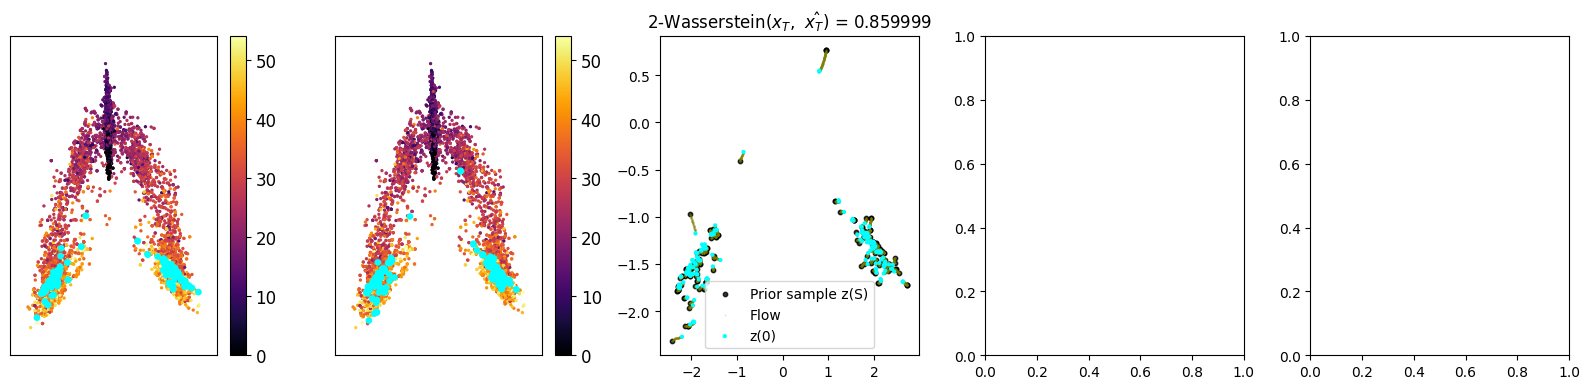

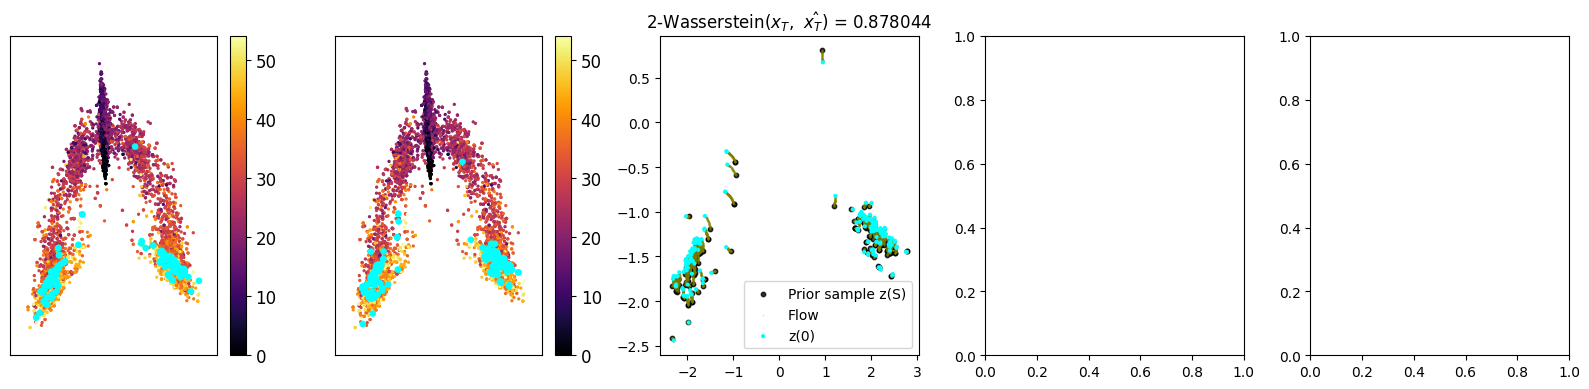

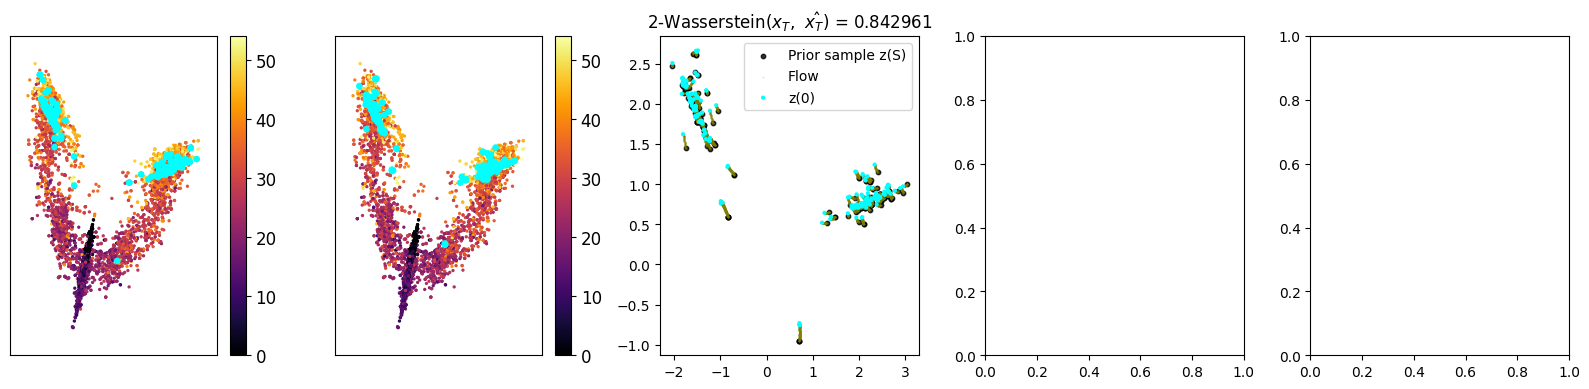

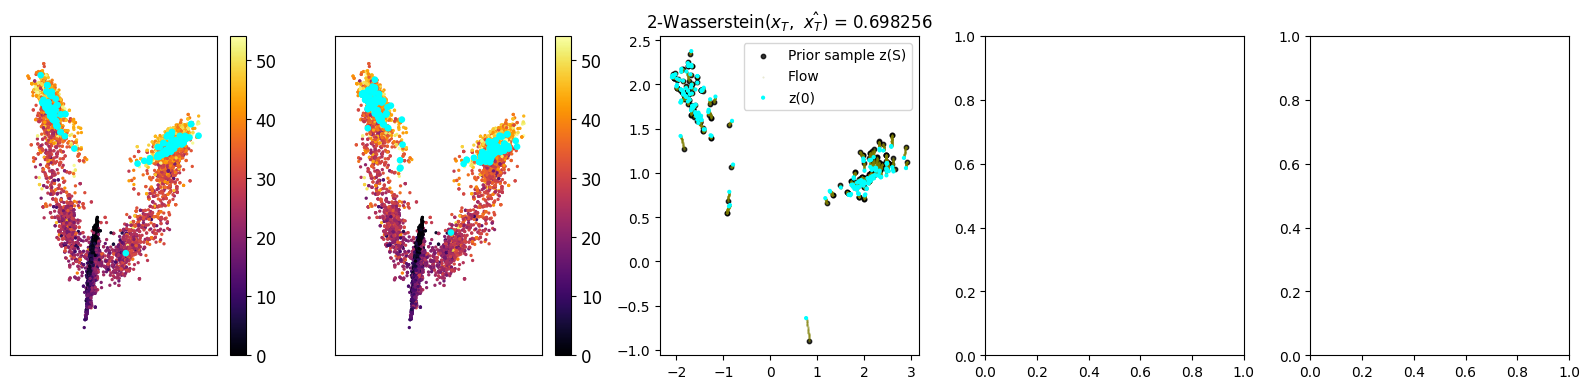

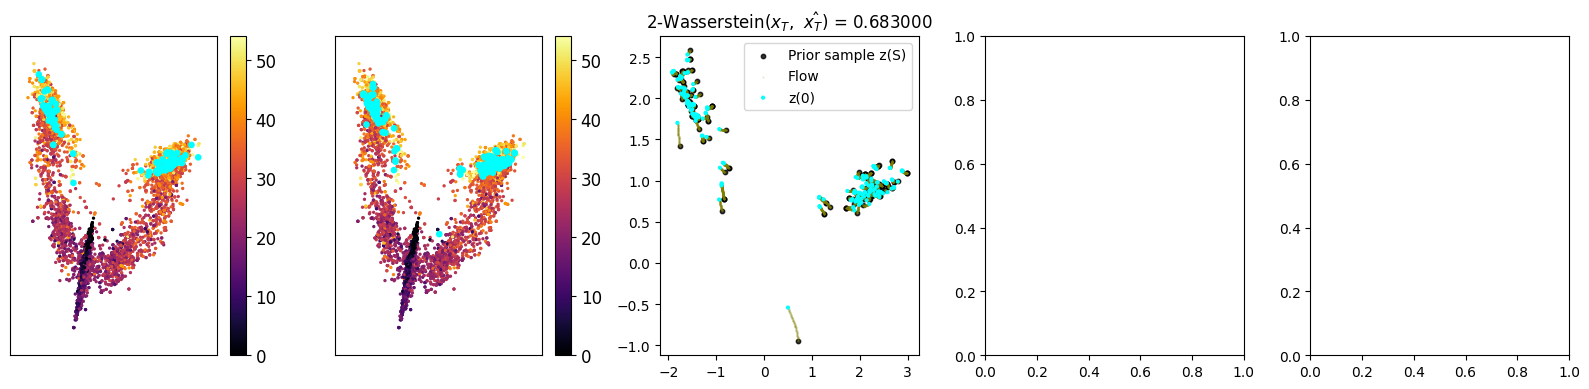

In [23]:
# Time-series SF2M 

num_iters = 10000
batch_size = 128

seeds = [1, 2, 3, 4, 5]
#seeds = [1]
dd_metrics_df = []

for seed in seeds:
    print("Training for seed =", seed, "...")
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_data, _, _ = get_train_dataset(seed)

    # compute full-batch OT matrix
    pis = [compute_pi(train_data[:,t], train_data[:,t+1]) for t in range(train_data.shape[1]-1)]

    fig, axes = plt.subplots(1,5, figsize=(16,4))
    axes = axes.flatten()

    sigma = None
    dim = train_data.shape[-1]
    model = MLP(dim=dim, w=64, time_varying=False)
    score_model = MLP(dim=dim, w=64, time_varying=False)
    print("Size of model", count_parameters(model) + count_parameters(score_model), "Parameters")
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(score_model.parameters()),
        lr=0.01,
        )

    for k in range(num_iters):
        # OT resample
        i_s = np.random.choice(train_data.shape[0], size=batch_size, )
        t_select = torch.tensor(np.random.choice(train_data.shape[1] - 2, size=batch_size, )) # minus 2 to leave out end point
        x0 = train_data[i_s, t_select, :]
        x1 = []
        for j,t in enumerate(t_select):
            choice = np.random.choice(train_data.shape[0], p=pis[t][i_s[j]] / pis[t][i_s[j]].sum())
            x1.append(train_data[choice, t+1, :])
        x1 = torch.stack(x1)

        # calculate regression loss
        optimizer.zero_grad()
        t = torch.rand(x0.shape[0], 1)
        mu_t = x0 + (x1 - x0) * F(t) / F(1)  # t * x1 + (1 - t) * x0
        sigma_t = F(t) - F(t) ** 2 / F(1)  # sigma * torch.sqrt(t - t**2)
        eps = torch.randn_like(x0)
        x = mu_t + sigma_t * eps
        sigma_t_prime = sigmat(t) ** 2 - 2 * F(t) * sigmat(t) ** 2 / F(1)
        sigma_t_prime_over_sigma_t = sigma_t_prime / (sigma_t + 1e-8)
        mu_t_prime = (x1 - x0) * sigmat(t) ** 2 / F(1)
        ut = sigma_t_prime_over_sigma_t * (x - mu_t) + mu_t_prime

        vt = model(x)
        st = score_model(x)
        score_target = -eps * sigmat(t) ** 2 / 2
        s_loss = torch.mean((sigma_t * st - score_target) ** 2)
        v_loss = torch.mean((vt - ut) ** 2)
        loss = v_loss + s_loss
        loss.backward() 
        optimizer.step()

        if (k + 1) % 1000 == 0:
            print(
                f"{k+1}: loss {loss.item():0.3f} sloss {s_loss.item():0.3f} vloss {v_loss.item():0.3f}"
            )

    # run final validation step
    val_data, val_graph, val_action = get_val_dataset(seed)
    val_dataset = TimeSeriesInterventionBifurcatingDataset(val_data, val_graph, val_action, time_step=1)
    val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.__len__(), shuffle=False) 
    with torch.no_grad():
        for val_idx, val_batch in enumerate(val_dataloader):
            x, a = val_batch
            x0, x1, t_select = preprocess_batch(x, training=False)
            ts = x.shape[1]
            pred_traj, dd_t2_values, pca, dd_df = validation_step(model=model, score_model=score_model, val_data_full=val_data, x0=x0, x1=x1, graph=true_graph, a=a, x=x, ts=ts, axes_list=axes)
            dd_metrics_df.append(dd_df)
            plot_sc_trajectories(pred_traj, val_data, a, dd_t2_values[1], pca, axes[2])

In [24]:
df = pd.concat(dd_metrics_df, axis=1)
print(df)
df_metrics_mean_std = pd.DataFrame()
df_metrics_mean_std["mean"] = df.mean(axis=1)
df_metrics_mean_std["std"] = df.std(axis=1)
print(df_metrics_mean_std)

                         0         0         0         0         0
t2/1-Wasserstein  0.500698  0.525616  0.532309  0.501465  0.482139
t2/2-Wasserstein  0.859999  0.878044  0.842961  0.698256  0.683000
t2/Linear_MMD    -0.325219  0.043119 -0.331432 -0.304158 -0.212068
t2/Poly_MMD      -4.680511  2.367210 -5.303841 -3.709156 -4.775135
t2/RBF_MMD        0.047702  0.055956  0.050916  0.065568  0.056551
t2/Mean_MSE       0.004175  0.009090  0.004278  0.003669  0.004021
t2/Mean_L2        0.064614  0.095339  0.065405  0.060571  0.063408
t2/Mean_L1        0.056767  0.078242  0.060356  0.056423  0.049498
t2/Median_MSE     0.688450  0.011552  0.652659  0.460216  0.163962
t2/Median_L2      0.829729  0.107481  0.807873  0.678392  0.404923
t2/Median_L1      0.577689  0.078783  0.501005  0.399891  0.202408
                      mean       std
t2/1-Wasserstein  0.508445  0.020403
t2/2-Wasserstein  0.792452  0.093931
t2/Linear_MMD    -0.225952  0.157867
t2/Poly_MMD      -3.220287  3.176087
t2/RBF_MMD 

Training for seed = 1 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.050 sloss 0.000 vloss 0.049 AUC 0.778
2000: loss 0.039 sloss 0.000 vloss 0.037 AUC 0.778
3000: loss 0.046 sloss 0.000 vloss 0.044 AUC 0.725
4000: loss 0.057 sloss 0.000 vloss 0.056 AUC 0.700
5000: loss 0.036 sloss 0.000 vloss 0.034 AUC 0.703
6000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.659
7000: loss 0.033 sloss 0.000 vloss 0.031 AUC 0.706
8000: loss 0.037 sloss 0.000 vloss 0.035 AUC 0.678
9000: loss 0.023 sloss 0.000 vloss 0.021 AUC 0.653
10000: loss 0.038 sloss 0.000 vloss 0.036 AUC 0.741
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.740625


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 2 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.035 sloss 0.000 vloss 0.033 AUC 0.809
2000: loss 0.050 sloss 0.000 vloss 0.049 AUC 0.831
3000: loss 0.033 sloss 0.000 vloss 0.032 AUC 0.778
4000: loss 0.064 sloss 0.000 vloss 0.062 AUC 0.766
5000: loss 0.051 sloss 0.000 vloss 0.050 AUC 0.769
6000: loss 0.040 sloss 0.000 vloss 0.039 AUC 0.722
7000: loss 0.028 sloss 0.000 vloss 0.027 AUC 0.709
8000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.691
9000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.697
10000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.703
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.703125


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 3 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.809
2000: loss 0.043 sloss 0.000 vloss 0.041 AUC 0.825
3000: loss 0.044 sloss 0.000 vloss 0.043 AUC 0.816
4000: loss 0.039 sloss 0.000 vloss 0.038 AUC 0.753
5000: loss 0.032 sloss 0.000 vloss 0.029 AUC 0.713
6000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.662
7000: loss 0.049 sloss 0.000 vloss 0.048 AUC 0.656
8000: loss 0.068 sloss 0.000 vloss 0.067 AUC 0.681
9000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.700
10000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.641
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.640625


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 4 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.054 sloss 0.000 vloss 0.053 AUC 0.759
2000: loss 0.032 sloss 0.000 vloss 0.030 AUC 0.791
3000: loss 0.062 sloss 0.000 vloss 0.061 AUC 0.800
4000: loss 0.050 sloss 0.000 vloss 0.048 AUC 0.791
5000: loss 0.064 sloss 0.000 vloss 0.062 AUC 0.778
6000: loss 0.025 sloss 0.000 vloss 0.023 AUC 0.734
7000: loss 0.036 sloss 0.000 vloss 0.035 AUC 0.762
8000: loss 0.034 sloss 0.000 vloss 0.033 AUC 0.769
9000: loss 0.041 sloss 0.000 vloss 0.040 AUC 0.722
10000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.762
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.7625


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 5 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.794
2000: loss 0.041 sloss 0.000 vloss 0.040 AUC 0.806
3000: loss 0.035 sloss 0.000 vloss 0.034 AUC 0.794
4000: loss 0.036 sloss 0.000 vloss 0.035 AUC 0.766
5000: loss 0.048 sloss 0.000 vloss 0.046 AUC 0.762
6000: loss 0.029 sloss 0.000 vloss 0.027 AUC 0.772
7000: loss 0.044 sloss 0.000 vloss 0.043 AUC 0.784
8000: loss 0.044 sloss 0.000 vloss 0.043 AUC 0.788
9000: loss 0.051 sloss 0.000 vloss 0.050 AUC 0.741
10000: loss 0.030 sloss 0.000 vloss 0.028 AUC 0.728
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.728125


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


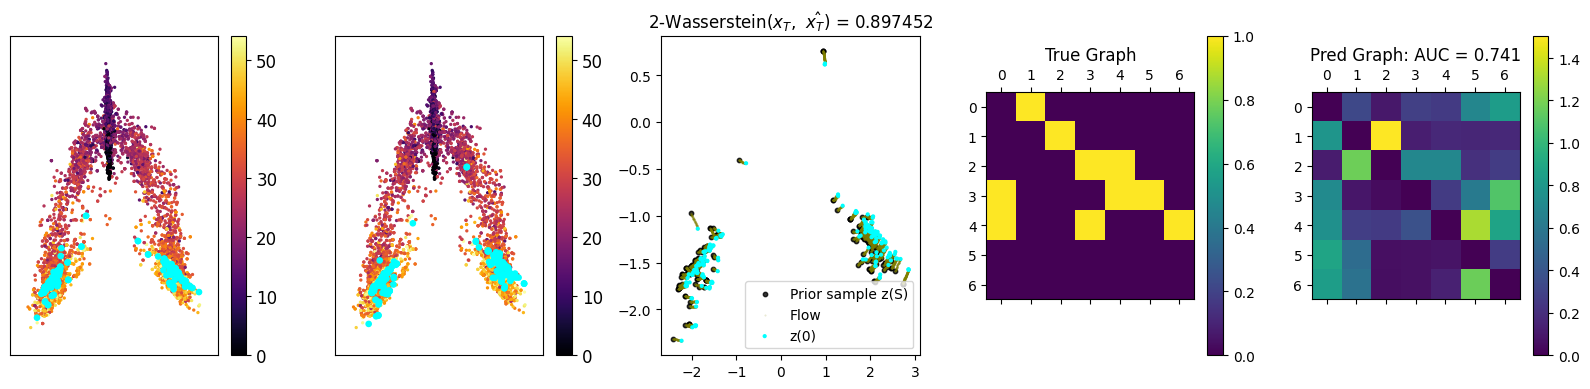

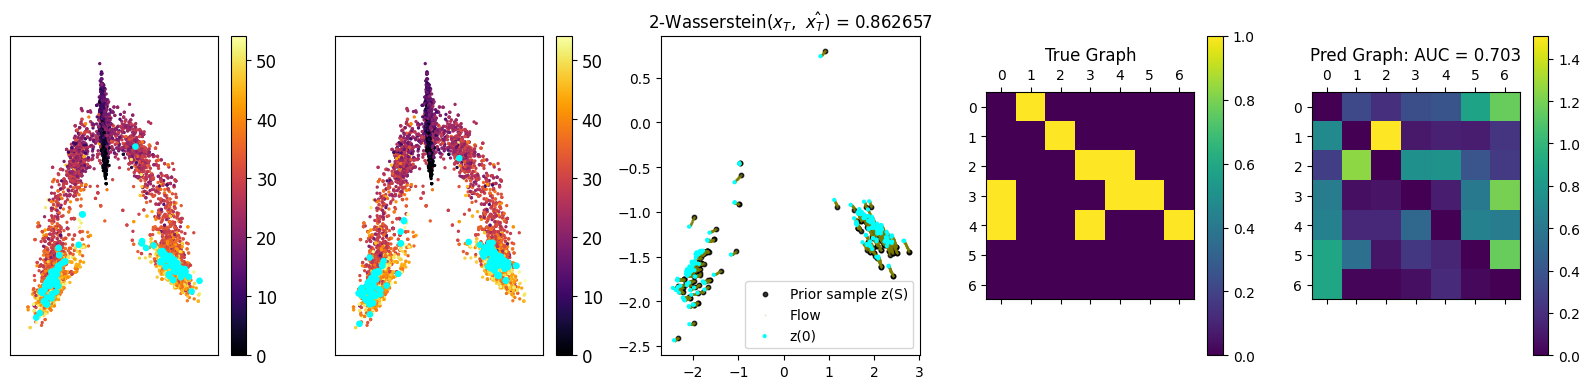

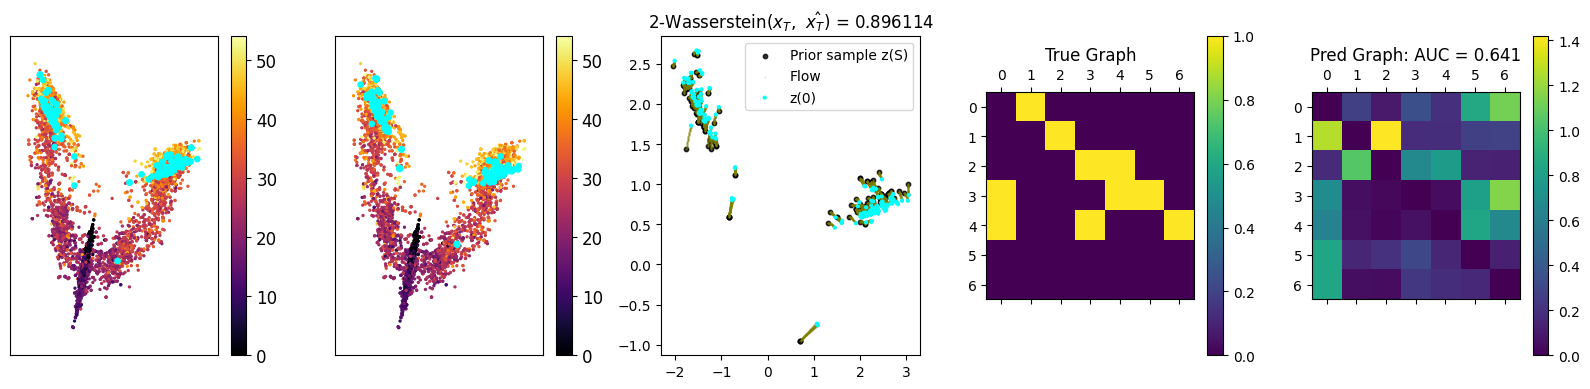

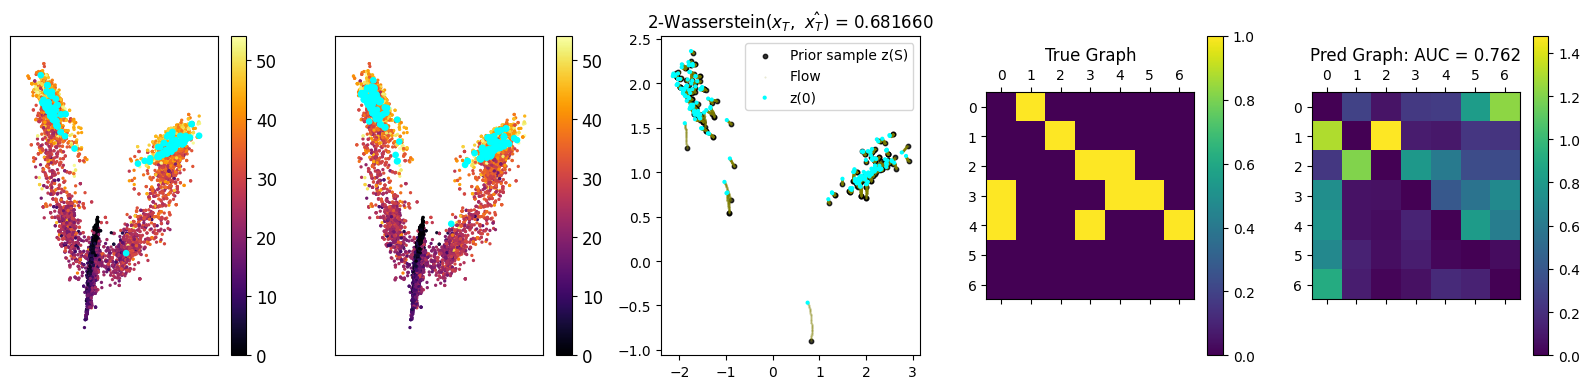

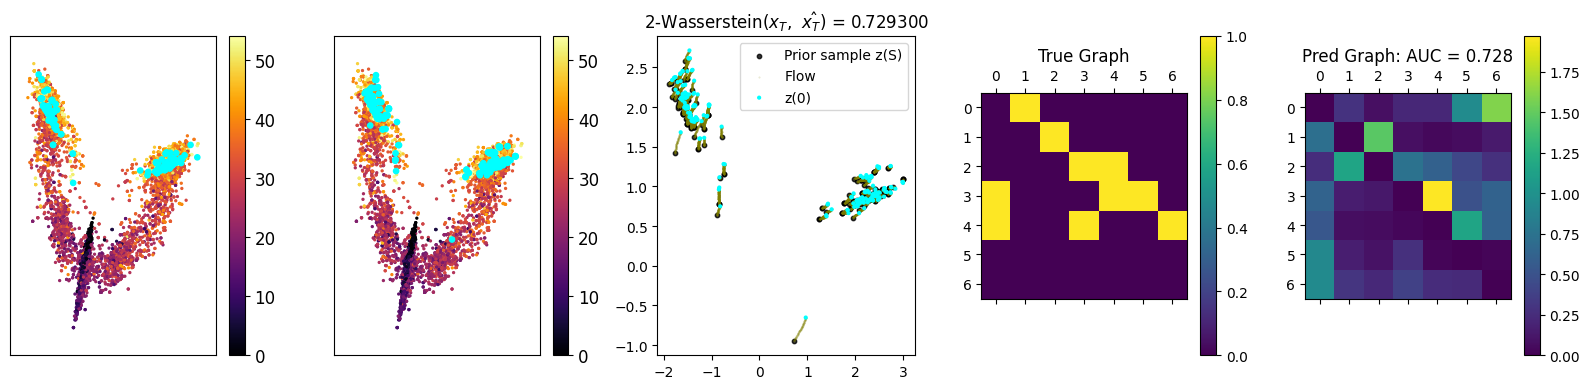

In [19]:
# Time-series NGM-SF2M 

num_iters = 10000
batch_size = 128
    
seeds = [1, 2, 3, 4, 5]
#seeds = [1]
dd_metrics_df = []

for seed in seeds:
    print("Training for seed =", seed, "...")
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_data, _, _ = get_train_dataset(seed)

    # compute full-batch OT matrix
    pis = [compute_pi(train_data[:,t], train_data[:,t+1]) for t in range(train_data.shape[1]-1)]
    
    fig, axes = plt.subplots(1,5, figsize=(16,4))
    axes = axes.flatten()

    sigma = None
    dim = train_data.shape[-1]
    dims = [100, 1]
    dims = [dim, *dims]
    ngm = NGM(dims, time_varying=False)
    ngm.reset_parameters()
    model = MLPODEF(ngm, dims, time_varying=False)
    model.reset_parameters()
    score_model = MLPODEF(ngm, dims, time_varying=False)
    score_model.reset_parameters()
    #model = MLPODEF(dims, time_varying=False)
    #model.reset_parameters()
    #score_model = MLP(dim=dim, w=64, time_varying=False)
    print("Size of model", count_parameters(model) + count_parameters(score_model), "Parameters")
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(score_model.parameters()),
        lr=0.01,
        )
    #optimizer = torch.optim.Adam(
    #    list(ngm.parameters()) + list(model.fc2.parameters()) + list(score_model.fc2.parameters()),
    #    lr=0.01,
    #    )

    for k in range(num_iters):
        # OT resample
        i_s = np.random.choice(train_data.shape[0], size=batch_size, )
        t_select = torch.tensor(np.random.choice(train_data.shape[1] - 2, size=batch_size, )) # minus 2 to leave out end point
        x0 = train_data[i_s, t_select, :]
        x1 = []
        for j,t in enumerate(t_select):
            choice = np.random.choice(train_data.shape[0], p=pis[t][i_s[j]] / pis[t][i_s[j]].sum())
            x1.append(train_data[choice, t+1, :])
        x1 = torch.stack(x1)

        # calculate regression loss
        optimizer.zero_grad()
        t = torch.rand(x0.shape[0], 1)
        mu_t = x0 + (x1 - x0) * F(t) / F(1)  # t * x1 + (1 - t) * x0
        sigma_t = F(t) - F(t) ** 2 / F(1)  # sigma * torch.sqrt(t - t**2)
        eps = torch.randn_like(x0)
        x = mu_t + sigma_t * eps
        sigma_t_prime = sigmat(t) ** 2 - 2 * F(t) * sigmat(t) ** 2 / F(1)
        sigma_t_prime_over_sigma_t = sigma_t_prime / (sigma_t + 1e-8)
        mu_t_prime = (x1 - x0) * sigmat(t) ** 2 / F(1)
        ut = sigma_t_prime_over_sigma_t * (x - mu_t) + mu_t_prime

        vt = model(x)
        st = score_model(x)
        score_target = -eps * sigmat(t) ** 2 / 2
        s_loss = torch.mean((sigma_t * st - score_target) ** 2)
        v_loss = torch.mean((vt - ut) ** 2)
        reg = 1e-5*ngm.l1_reg()
        loss = v_loss + s_loss + 2*reg
        loss.backward()
        optimizer.step()

        if (k + 1) % 1000 == 0:
            G = ngm.get_structure().cpu().detach().numpy()  # [i, j]
            self_loop_mask = ~np.eye(G.shape[-1], dtype=bool)
            df_graph_metrics = compute_metrics((true_graph[self_loop_mask]).flatten(), (G[self_loop_mask]).flatten())
            auc = df_graph_metrics[0].values[0]
            print(
                f"{k+1}: loss {loss.item():0.3f} sloss {s_loss.item():0.3f} vloss {v_loss.item():0.3f} AUC {auc:0.3f}"
            )

    # run final validation step 
    val_data, val_graph, val_action = get_val_dataset(seed)
    val_dataset = TimeSeriesInterventionBifurcatingDataset(val_data, val_graph, val_action, time_step=1)
    val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.__len__(), shuffle=False)
    with torch.no_grad():
        for val_idx, val_batch in enumerate(val_dataloader):
            x, a = val_batch
            x0, x1, t_select = preprocess_batch(x, training=False)
            ts = x.shape[1]
            G = ngm.get_structure().cpu().detach().numpy()  # [i, j]
            pred_traj, dd_t2_values, pca, dd_df = validation_step(model=model, score_model=score_model, val_data_full=val_data, x0=x0, x1=x1, graph=true_graph, a=a, G=G, x=x, ts=ts, axes_list=axes)
            dd_metrics_df.append(dd_df)
            plot_sc_trajectories(pred_traj, val_data, a, dd_t2_values[1], pca, axes[2])

In [20]:
df = pd.concat(dd_metrics_df, axis=1)
print(df)
df_metrics_mean_std = pd.DataFrame()
df_metrics_mean_std["mean"] = df.mean(axis=1)
df_metrics_mean_std["std"] = df.std(axis=1)
print(df_metrics_mean_std)

                         0         0         0         0         0
t2/1-Wasserstein  0.565242  0.529580  0.581894  0.465752  0.559391
t2/2-Wasserstein  0.897452  0.862657  0.896114  0.681660  0.729300
t2/Linear_MMD    -0.262958 -0.019897 -0.263358 -0.320112 -0.159458
t2/Poly_MMD      -4.240131  1.507973 -4.694786 -3.697849 -4.101757
t2/RBF_MMD        0.066207  0.057521  0.063474  0.055389  0.075871
t2/Mean_MSE       0.013170  0.003810  0.012161  0.002218  0.010596
t2/Mean_L2        0.114762  0.061729  0.110277  0.047094  0.102938
t2/Mean_L1        0.093460  0.045878  0.095291  0.038880  0.087422
t2/Median_MSE     0.830930  0.010528  0.731285  0.509869  0.113279
t2/Median_L2      0.911554  0.102607  0.855152  0.714051  0.336569
t2/Median_L1      0.664580  0.083915  0.556725  0.397119  0.174190
AUCROC            0.740625  0.703125  0.640625  0.762500  0.728125
AP                0.441351  0.420676  0.399947  0.462149  0.484349
AUCROC_sym        0.740625  0.703125  0.640625  0.762500  0.72

In [21]:
sigma_min = 0.1

def sigmat(t):
    return torch.ones_like(t) * sigma_min
    

def F(t):
    t = t * 1.0
    if isinstance(t, float):
        t = torch.tensor(t)
    return t * sigma_min**2

class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, time_varying=False, reverse=False):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.time_varying = time_varying
        self.reverse = reverse

    # Drift
    def f(self, t, y):
        if self.reverse:
            t = 1 - t
        if len(t.shape) == len(y.shape):
            if self.time_varying:
                x = torch.cat([y, t], 1)
            else:
                x = y
        else:
            if self.time_varying:
                x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
            else: 
                x = y
        if self.reverse:
            return -self.drift(x) + self.score(x)
        return self.drift(x) + self.score(x)

    # Diffusion
    def g(self, t, y):
        return sigmat(t) * torch.ones_like(y)

Training for seed = 1 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.050 sloss 0.000 vloss 0.049 AUC 0.762
2000: loss 0.039 sloss 0.000 vloss 0.038 AUC 0.775
3000: loss 0.046 sloss 0.000 vloss 0.044 AUC 0.728
4000: loss 0.058 sloss 0.000 vloss 0.056 AUC 0.741
5000: loss 0.036 sloss 0.000 vloss 0.034 AUC 0.675
6000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.681
7000: loss 0.033 sloss 0.000 vloss 0.031 AUC 0.662
8000: loss 0.037 sloss 0.000 vloss 0.035 AUC 0.681
9000: loss 0.023 sloss 0.000 vloss 0.021 AUC 0.647
10000: loss 0.036 sloss 0.000 vloss 0.034 AUC 0.700
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.7


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 2 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.035 sloss 0.000 vloss 0.033 AUC 0.809
2000: loss 0.050 sloss 0.000 vloss 0.049 AUC 0.834
3000: loss 0.033 sloss 0.000 vloss 0.032 AUC 0.784
4000: loss 0.064 sloss 0.000 vloss 0.063 AUC 0.766
5000: loss 0.052 sloss 0.000 vloss 0.050 AUC 0.747
6000: loss 0.040 sloss 0.000 vloss 0.039 AUC 0.719
7000: loss 0.028 sloss 0.000 vloss 0.027 AUC 0.706
8000: loss 0.056 sloss 0.000 vloss 0.055 AUC 0.706
9000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.697
10000: loss 0.039 sloss 0.000 vloss 0.037 AUC 0.722
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.721875


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 3 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.037 sloss 0.000 vloss 0.035 AUC 0.809
2000: loss 0.042 sloss 0.000 vloss 0.041 AUC 0.825
3000: loss 0.044 sloss 0.000 vloss 0.042 AUC 0.809
4000: loss 0.039 sloss 0.000 vloss 0.037 AUC 0.787
5000: loss 0.034 sloss 0.000 vloss 0.032 AUC 0.684
6000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.691
7000: loss 0.048 sloss 0.000 vloss 0.046 AUC 0.709
8000: loss 0.066 sloss 0.000 vloss 0.065 AUC 0.681
9000: loss 0.040 sloss 0.000 vloss 0.038 AUC 0.672
10000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.725
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.725


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 4 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.054 sloss 0.000 vloss 0.053 AUC 0.759
2000: loss 0.031 sloss 0.000 vloss 0.030 AUC 0.800
3000: loss 0.062 sloss 0.000 vloss 0.061 AUC 0.800
4000: loss 0.051 sloss 0.000 vloss 0.049 AUC 0.787
5000: loss 0.064 sloss 0.000 vloss 0.062 AUC 0.803
6000: loss 0.025 sloss 0.000 vloss 0.023 AUC 0.738
7000: loss 0.037 sloss 0.000 vloss 0.035 AUC 0.747
8000: loss 0.036 sloss 0.000 vloss 0.035 AUC 0.775
9000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.741
10000: loss 0.037 sloss 0.000 vloss 0.035 AUC 0.738
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.7375


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 5 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.797
2000: loss 0.041 sloss 0.000 vloss 0.040 AUC 0.806
3000: loss 0.035 sloss 0.000 vloss 0.033 AUC 0.806
4000: loss 0.034 sloss 0.000 vloss 0.033 AUC 0.778
5000: loss 0.048 sloss 0.000 vloss 0.046 AUC 0.772
6000: loss 0.029 sloss 0.000 vloss 0.027 AUC 0.766
7000: loss 0.044 sloss 0.000 vloss 0.043 AUC 0.756
8000: loss 0.044 sloss 0.000 vloss 0.042 AUC 0.797
9000: loss 0.051 sloss 0.000 vloss 0.050 AUC 0.759
10000: loss 0.028 sloss 0.000 vloss 0.027 AUC 0.731
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.7312500000000001


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


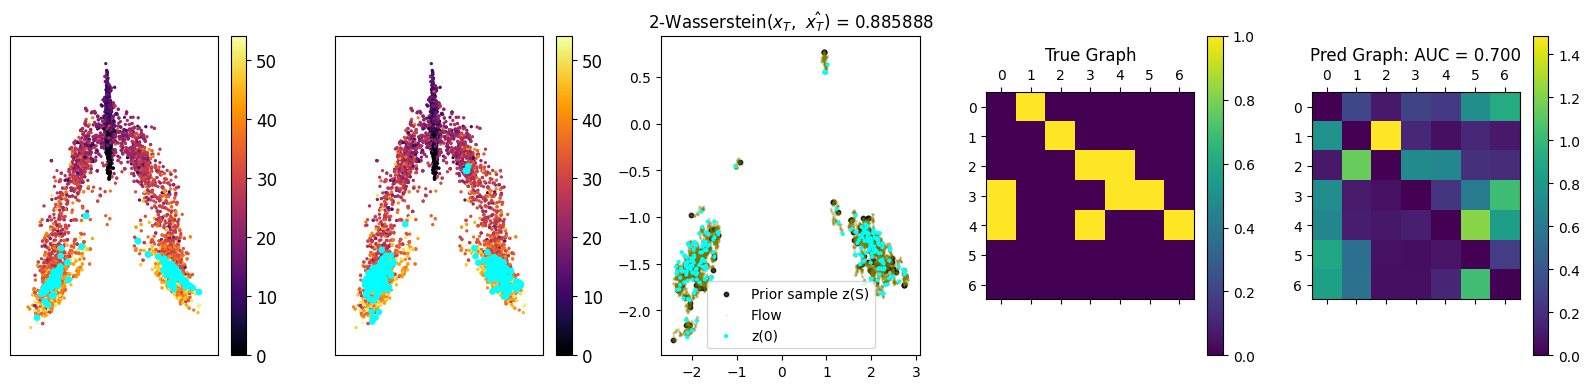

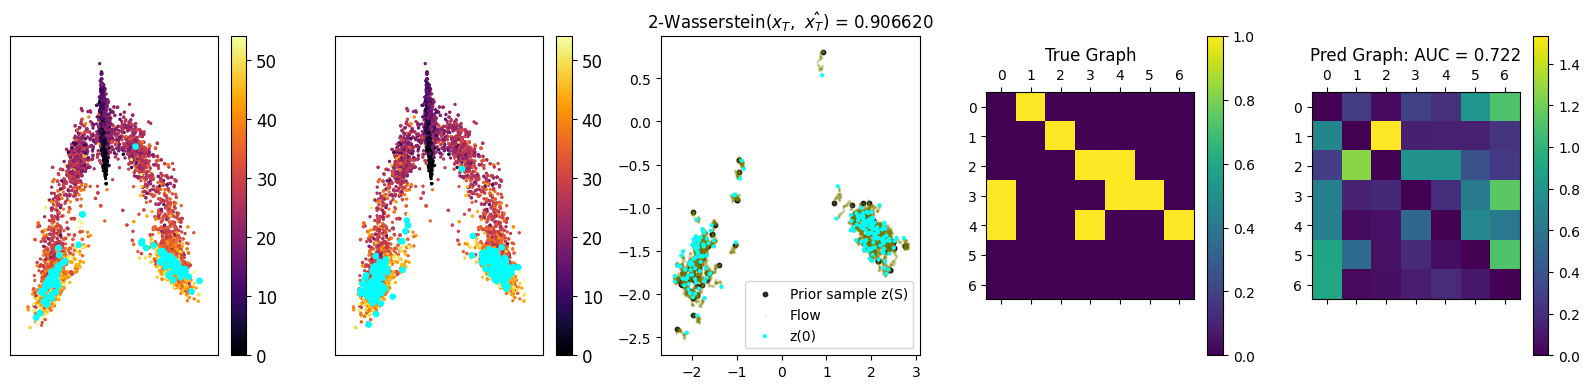

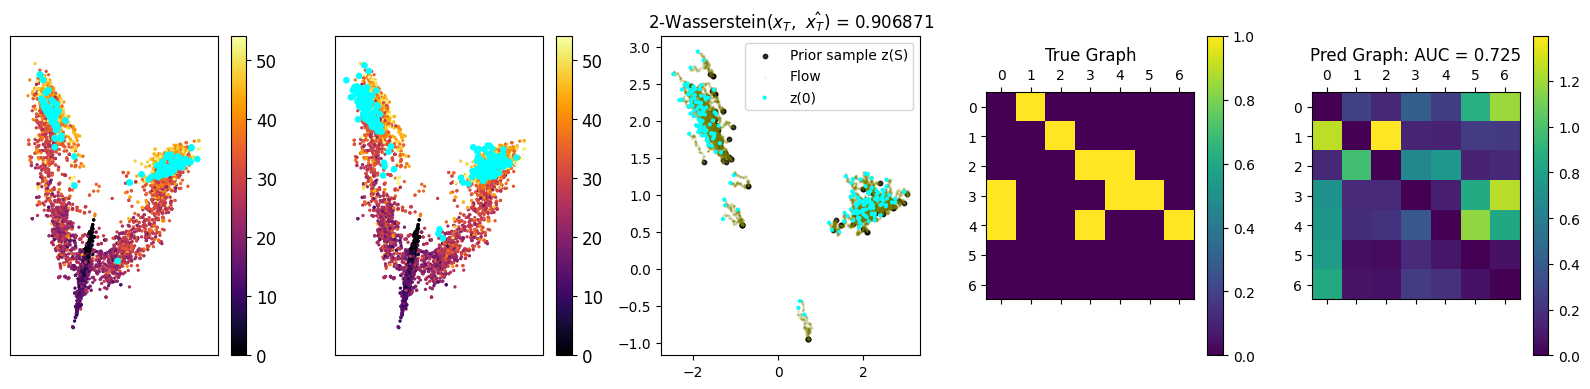

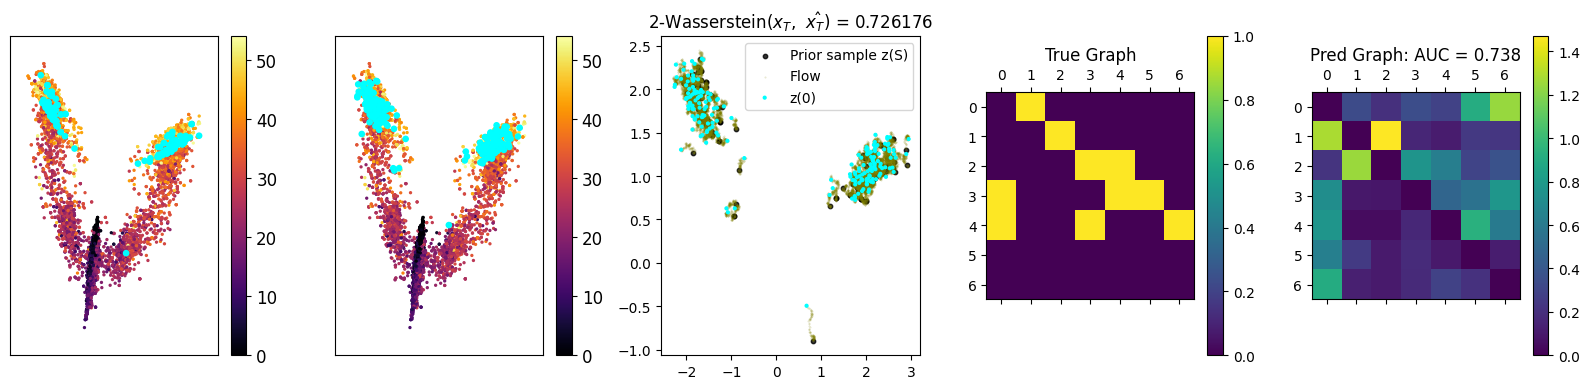

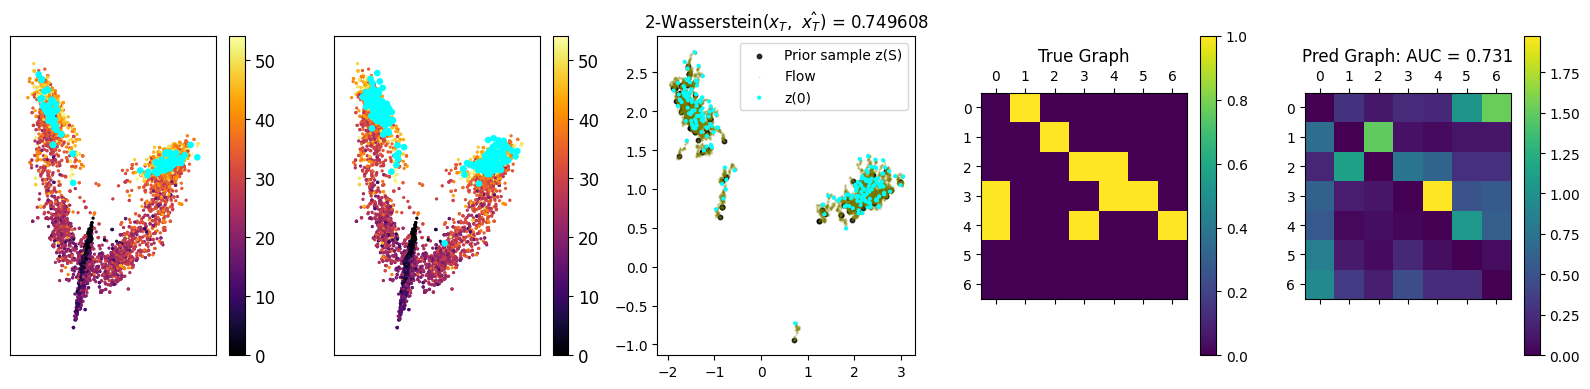

In [22]:
# Time-series NGM-SF2M 

num_iters = 10000
batch_size = 128
    
seeds = [1, 2, 3, 4, 5]
#seeds = [1]
dd_metrics_df = []

for seed in seeds:
    print("Training for seed =", seed, "...")
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_data, _, _ = get_train_dataset(seed)

    # compute full-batch OT matrix
    pis = [compute_pi(train_data[:,t], train_data[:,t+1]) for t in range(train_data.shape[1]-1)]
    
    fig, axes = plt.subplots(1,5, figsize=(16,4))
    axes = axes.flatten()

    sigma = None
    dim = train_data.shape[-1]
    dims = [100, 1]
    dims = [dim, *dims]
    ngm = NGM(dims, time_varying=False)
    ngm.reset_parameters()
    model = MLPODEF(ngm, dims, time_varying=False)
    model.reset_parameters()
    score_model = MLPODEF(ngm, dims, time_varying=False)
    score_model.reset_parameters()
    #model = MLPODEF(dims, time_varying=False)
    #model.reset_parameters()
    #score_model = MLP(dim=dim, w=64, time_varying=False)
    print("Size of model", count_parameters(model) + count_parameters(score_model), "Parameters")
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(score_model.parameters()),
        lr=0.01,
        )
    #optimizer = torch.optim.Adam(
    #    list(ngm.parameters()) + list(model.fc2.parameters()) + list(score_model.fc2.parameters()),
    #    lr=0.01,
    #    )

    for k in range(num_iters):
        # OT resample
        i_s = np.random.choice(train_data.shape[0], size=batch_size, )
        t_select = torch.tensor(np.random.choice(train_data.shape[1] - 2, size=batch_size, )) # minus 2 to leave out end point
        x0 = train_data[i_s, t_select, :]
        x1 = []
        for j,t in enumerate(t_select):
            choice = np.random.choice(train_data.shape[0], p=pis[t][i_s[j]] / pis[t][i_s[j]].sum())
            x1.append(train_data[choice, t+1, :])
        x1 = torch.stack(x1)

        # calculate regression loss
        optimizer.zero_grad()
        t = torch.rand(x0.shape[0], 1)
        mu_t = x0 + (x1 - x0) * F(t) / F(1)  # t * x1 + (1 - t) * x0
        sigma_t = F(t) - F(t) ** 2 / F(1)  # sigma * torch.sqrt(t - t**2)
        eps = torch.randn_like(x0)
        x = mu_t + sigma_t * eps
        sigma_t_prime = sigmat(t) ** 2 - 2 * F(t) * sigmat(t) ** 2 / F(1)
        sigma_t_prime_over_sigma_t = sigma_t_prime / (sigma_t + 1e-8)
        mu_t_prime = (x1 - x0) * sigmat(t) ** 2 / F(1)
        ut = sigma_t_prime_over_sigma_t * (x - mu_t) + mu_t_prime

        vt = model(x)
        st = score_model(x)
        score_target = -eps * sigmat(t) ** 2 / 2
        s_loss = torch.mean((sigma_t * st - score_target) ** 2)
        v_loss = torch.mean((vt - ut) ** 2)
        reg = 1e-5*ngm.l1_reg()
        loss = v_loss + s_loss + 2*reg
        loss.backward()
        optimizer.step()

        if (k + 1) % 1000 == 0:
            G = ngm.get_structure().cpu().detach().numpy()  # [i, j]
            self_loop_mask = ~np.eye(G.shape[-1], dtype=bool)
            df_graph_metrics = compute_metrics((true_graph[self_loop_mask]).flatten(), (G[self_loop_mask]).flatten())
            auc = df_graph_metrics[0].values[0]
            print(
                f"{k+1}: loss {loss.item():0.3f} sloss {s_loss.item():0.3f} vloss {v_loss.item():0.3f} AUC {auc:0.3f}"
            )

    # run final validation step 
    val_data, val_graph, val_action = get_val_dataset(seed)
    val_dataset = TimeSeriesInterventionBifurcatingDataset(val_data, val_graph, val_action, time_step=1)
    val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.__len__(), shuffle=False)
    with torch.no_grad():
        for val_idx, val_batch in enumerate(val_dataloader):
            x, a = val_batch
            x0, x1, t_select = preprocess_batch(x, training=False)
            ts = x.shape[1]
            G = ngm.get_structure().cpu().detach().numpy()  # [i, j]
            pred_traj, dd_t2_values, pca, dd_df = validation_step(model=model, score_model=score_model, val_data_full=val_data, x0=x0, x1=x1, graph=true_graph, a=a, G=G, x=x, ts=ts, axes_list=axes)
            dd_metrics_df.append(dd_df)
            plot_sc_trajectories(pred_traj, val_data, a, dd_t2_values[1], pca, axes[2])

In [23]:
df = pd.concat(dd_metrics_df, axis=1)
print(df)
df_metrics_mean_std = pd.DataFrame()
df_metrics_mean_std["mean"] = df.mean(axis=1)
df_metrics_mean_std["std"] = df.std(axis=1)
print(df_metrics_mean_std)

                         0         0         0         0         0
t2/1-Wasserstein  0.573610  0.608723  0.681009  0.554088  0.598766
t2/2-Wasserstein  0.885888  0.906620  0.906871  0.726176  0.749608
t2/Linear_MMD    -0.354570  0.028260 -0.282053 -0.359532 -0.196968
t2/Poly_MMD      -4.842400  2.226082 -4.774059 -3.974808 -4.365150
t2/RBF_MMD        0.051108  0.058665  0.077114  0.060770  0.072065
t2/Mean_MSE       0.006033  0.011405  0.015409  0.005208  0.010162
t2/Mean_L2        0.077674  0.106796  0.124133  0.072164  0.100809
t2/Mean_L1        0.060579  0.095067  0.090308  0.061104  0.089695
t2/Median_MSE     0.665962  0.010341  0.613329  0.546770  0.133926
t2/Median_L2      0.816065  0.101692  0.783153  0.739439  0.365959
t2/Median_L1      0.565365  0.071927  0.529737  0.459145  0.199910
AUCROC            0.700000  0.721875  0.725000  0.737500  0.731250
AP                0.413174  0.426271  0.441949  0.446198  0.492029
AUCROC_sym        0.700000  0.721875  0.725000  0.737500  0.73

In [24]:
sigma_min = 0.001

def sigmat(t):
    return torch.ones_like(t) * sigma_min
    

def F(t):
    t = t * 1.0
    if isinstance(t, float):
        t = torch.tensor(t)
    return t * sigma_min**2

class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, time_varying=False, reverse=False):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.time_varying = time_varying
        self.reverse = reverse

    # Drift
    def f(self, t, y):
        if self.reverse:
            t = 1 - t
        if len(t.shape) == len(y.shape):
            if self.time_varying:
                x = torch.cat([y, t], 1)
            else:
                x = y
        else:
            if self.time_varying:
                x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
            else: 
                x = y
        if self.reverse:
            return -self.drift(x) + self.score(x)
        return self.drift(x) + self.score(x)

    # Diffusion
    def g(self, t, y):
        return sigmat(t) * torch.ones_like(y)

Training for seed = 1 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.050 sloss 0.000 vloss 0.049 AUC 0.772
2000: loss 0.039 sloss 0.000 vloss 0.038 AUC 0.784
3000: loss 0.046 sloss 0.000 vloss 0.044 AUC 0.716
4000: loss 0.058 sloss 0.000 vloss 0.056 AUC 0.691
5000: loss 0.036 sloss 0.000 vloss 0.034 AUC 0.694
6000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.675
7000: loss 0.033 sloss 0.000 vloss 0.032 AUC 0.713
8000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.688
9000: loss 0.023 sloss 0.000 vloss 0.021 AUC 0.666
10000: loss 0.036 sloss 0.000 vloss 0.034 AUC 0.697
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.696875


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 2 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.034 sloss 0.000 vloss 0.033 AUC 0.812
2000: loss 0.051 sloss 0.000 vloss 0.049 AUC 0.825
3000: loss 0.033 sloss 0.000 vloss 0.032 AUC 0.787
4000: loss 0.064 sloss 0.000 vloss 0.062 AUC 0.756
5000: loss 0.052 sloss 0.000 vloss 0.050 AUC 0.731
6000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.709
7000: loss 0.028 sloss 0.000 vloss 0.027 AUC 0.713
8000: loss 0.056 sloss 0.000 vloss 0.055 AUC 0.725
9000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.728
10000: loss 0.039 sloss 0.000 vloss 0.037 AUC 0.694
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.69375


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 3 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.812
2000: loss 0.042 sloss 0.000 vloss 0.040 AUC 0.831
3000: loss 0.043 sloss 0.000 vloss 0.042 AUC 0.816
4000: loss 0.039 sloss 0.000 vloss 0.037 AUC 0.784
5000: loss 0.029 sloss 0.000 vloss 0.027 AUC 0.753
6000: loss 0.056 sloss 0.000 vloss 0.054 AUC 0.659
7000: loss 0.048 sloss 0.000 vloss 0.046 AUC 0.666
8000: loss 0.068 sloss 0.000 vloss 0.066 AUC 0.678
9000: loss 0.040 sloss 0.000 vloss 0.038 AUC 0.688
10000: loss 0.041 sloss 0.000 vloss 0.039 AUC 0.659
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.6593749999999999


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 4 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.054 sloss 0.000 vloss 0.053 AUC 0.756
2000: loss 0.032 sloss 0.000 vloss 0.030 AUC 0.806
3000: loss 0.063 sloss 0.000 vloss 0.061 AUC 0.787
4000: loss 0.054 sloss 0.000 vloss 0.052 AUC 0.728
5000: loss 0.063 sloss 0.000 vloss 0.062 AUC 0.806
6000: loss 0.026 sloss 0.000 vloss 0.024 AUC 0.747
7000: loss 0.036 sloss 0.000 vloss 0.035 AUC 0.775
8000: loss 0.035 sloss 0.000 vloss 0.033 AUC 0.775
9000: loss 0.037 sloss 0.000 vloss 0.035 AUC 0.750
10000: loss 0.038 sloss 0.000 vloss 0.036 AUC 0.675
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.675


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


Training for seed = 5 ...
Size of model 12614 Parameters


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


1000: loss 0.037 sloss 0.000 vloss 0.036 AUC 0.800
2000: loss 0.041 sloss 0.000 vloss 0.040 AUC 0.778
3000: loss 0.035 sloss 0.000 vloss 0.034 AUC 0.775
4000: loss 0.035 sloss 0.000 vloss 0.033 AUC 0.772
5000: loss 0.048 sloss 0.000 vloss 0.046 AUC 0.772
6000: loss 0.030 sloss 0.000 vloss 0.029 AUC 0.750
7000: loss 0.045 sloss 0.000 vloss 0.043 AUC 0.775
8000: loss 0.044 sloss 0.000 vloss 0.042 AUC 0.769
9000: loss 0.051 sloss 0.000 vloss 0.050 AUC 0.738
10000: loss 0.028 sloss 0.000 vloss 0.026 AUC 0.772
Starting traj inference ...


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/torchsde/_core/misc.py:29: UserWarning: `sdeint`: Unexpected arguments {'solver': 'euler'}
  warnings.warn(f"{msg}: Unexpected arguments {unused_kwargs}")


... Ending traj inference
SHD = 23 AUC = 0.7718750000000001


/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(
/home/mila/l/lazar.atanackovic/miniconda3/envs/ti-env/lib/python3.10/site-packages/scprep/plot/scatter.py:430: UserWarning: `c` is a color array and cannot be used to create a legend. To interpret these values as labels instead, provide a `cmap` dictionary with label-color pairs.
  warnings.warn(


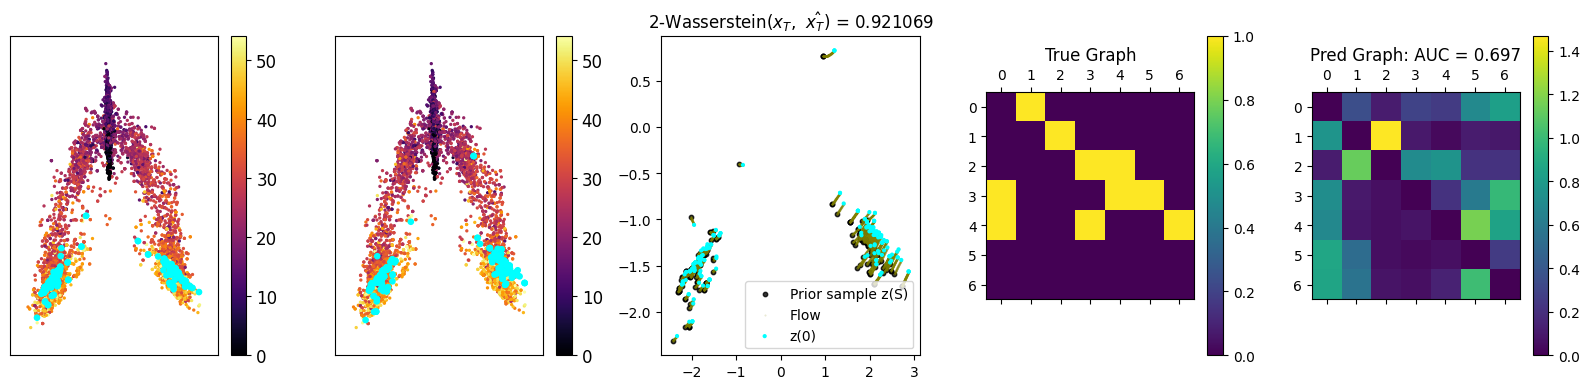

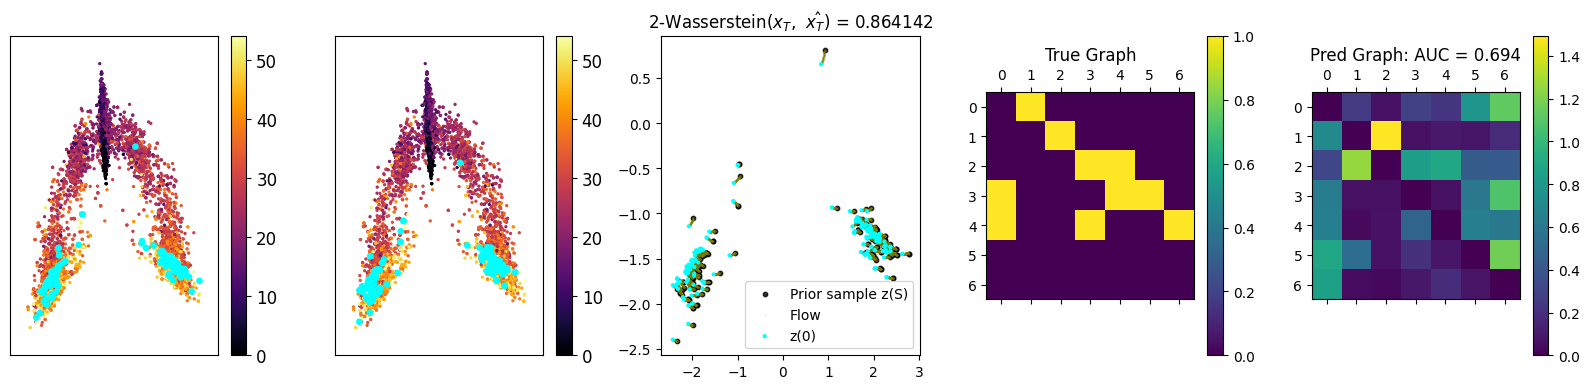

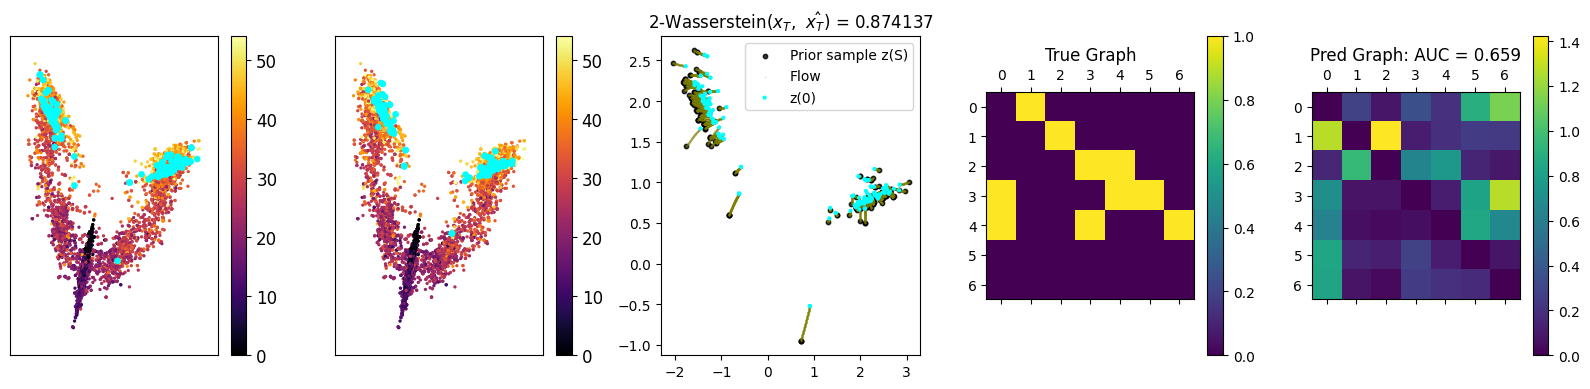

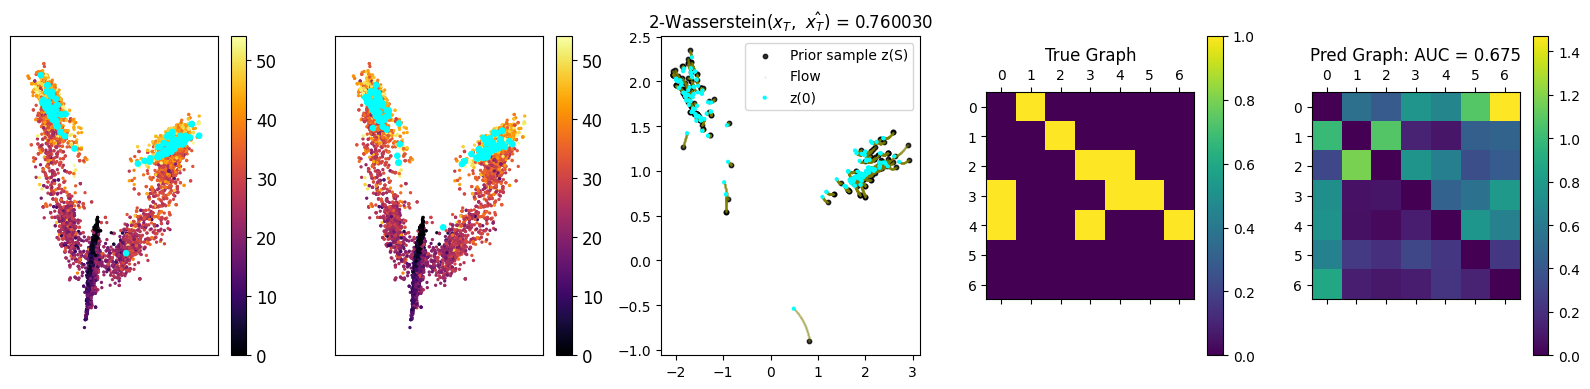

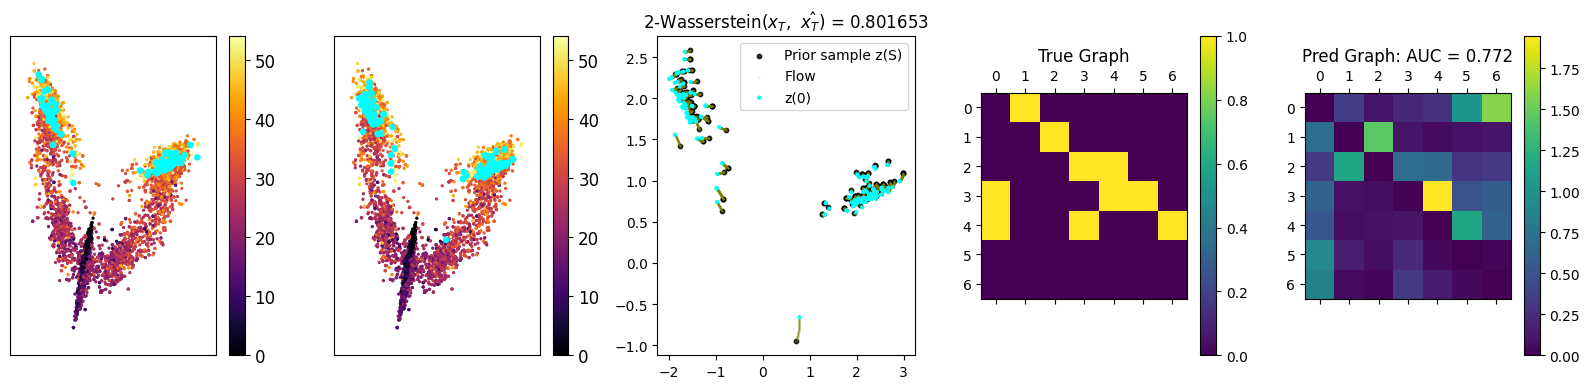

In [25]:
# Time-series NGM-SF2M 

num_iters = 10000
batch_size = 128
    
seeds = [1, 2, 3, 4, 5]
#seeds = [1]
dd_metrics_df = []

for seed in seeds:
    print("Training for seed =", seed, "...")
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_data, _, _ = get_train_dataset(seed)

    # compute full-batch OT matrix
    pis = [compute_pi(train_data[:,t], train_data[:,t+1]) for t in range(train_data.shape[1]-1)]
    
    fig, axes = plt.subplots(1,5, figsize=(16,4))
    axes = axes.flatten()

    sigma = None
    dim = train_data.shape[-1]
    dims = [100, 1]
    dims = [dim, *dims]
    ngm = NGM(dims, time_varying=False)
    ngm.reset_parameters()
    model = MLPODEF(ngm, dims, time_varying=False)
    model.reset_parameters()
    score_model = MLPODEF(ngm, dims, time_varying=False)
    score_model.reset_parameters()
    #model = MLPODEF(dims, time_varying=False)
    #model.reset_parameters()
    #score_model = MLP(dim=dim, w=64, time_varying=False)
    print("Size of model", count_parameters(model) + count_parameters(score_model), "Parameters")
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(score_model.parameters()),
        lr=0.01,
        )
    #optimizer = torch.optim.Adam(
    #    list(ngm.parameters()) + list(model.fc2.parameters()) + list(score_model.fc2.parameters()),
    #    lr=0.01,
    #    )

    for k in range(num_iters):
        # OT resample
        i_s = np.random.choice(train_data.shape[0], size=batch_size, )
        t_select = torch.tensor(np.random.choice(train_data.shape[1] - 2, size=batch_size, )) # minus 2 to leave out end point
        x0 = train_data[i_s, t_select, :]
        x1 = []
        for j,t in enumerate(t_select):
            choice = np.random.choice(train_data.shape[0], p=pis[t][i_s[j]] / pis[t][i_s[j]].sum())
            x1.append(train_data[choice, t+1, :])
        x1 = torch.stack(x1)

        # calculate regression loss
        optimizer.zero_grad()
        t = torch.rand(x0.shape[0], 1)
        mu_t = x0 + (x1 - x0) * F(t) / F(1)  # t * x1 + (1 - t) * x0
        sigma_t = F(t) - F(t) ** 2 / F(1)  # sigma * torch.sqrt(t - t**2)
        eps = torch.randn_like(x0)
        x = mu_t + sigma_t * eps
        sigma_t_prime = sigmat(t) ** 2 - 2 * F(t) * sigmat(t) ** 2 / F(1)
        sigma_t_prime_over_sigma_t = sigma_t_prime / (sigma_t + 1e-8)
        mu_t_prime = (x1 - x0) * sigmat(t) ** 2 / F(1)
        ut = sigma_t_prime_over_sigma_t * (x - mu_t) + mu_t_prime

        vt = model(x)
        st = score_model(x)
        score_target = -eps * sigmat(t) ** 2 / 2
        s_loss = torch.mean((sigma_t * st - score_target) ** 2)
        v_loss = torch.mean((vt - ut) ** 2)
        reg = 1e-5*ngm.l1_reg()
        loss = v_loss + s_loss + 2*reg
        loss.backward()
        optimizer.step()

        if (k + 1) % 1000 == 0:
            G = ngm.get_structure().cpu().detach().numpy()  # [i, j]
            self_loop_mask = ~np.eye(G.shape[-1], dtype=bool)
            df_graph_metrics = compute_metrics((true_graph[self_loop_mask]).flatten(), (G[self_loop_mask]).flatten())
            auc = df_graph_metrics[0].values[0]
            print(
                f"{k+1}: loss {loss.item():0.3f} sloss {s_loss.item():0.3f} vloss {v_loss.item():0.3f} AUC {auc:0.3f}"
            )

    # run final validation step 
    val_data, val_graph, val_action = get_val_dataset(seed)
    val_dataset = TimeSeriesInterventionBifurcatingDataset(val_data, val_graph, val_action, time_step=1)
    val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.__len__(), shuffle=False)
    with torch.no_grad():
        for val_idx, val_batch in enumerate(val_dataloader):
            x, a = val_batch
            x0, x1, t_select = preprocess_batch(x, training=False)
            ts = x.shape[1]
            G = ngm.get_structure().cpu().detach().numpy()  # [i, j]
            pred_traj, dd_t2_values, pca, dd_df = validation_step(model=model, score_model=score_model, val_data_full=val_data, x0=x0, x1=x1, graph=true_graph, a=a, G=G, x=x, ts=ts, axes_list=axes)
            dd_metrics_df.append(dd_df)
            plot_sc_trajectories(pred_traj, val_data, a, dd_t2_values[1], pca, axes[2])

In [26]:
df = pd.concat(dd_metrics_df, axis=1)
print(df)
df_metrics_mean_std = pd.DataFrame()
df_metrics_mean_std["mean"] = df.mean(axis=1)
df_metrics_mean_std["std"] = df.std(axis=1)
print(df_metrics_mean_std)

                         0         0         0         0         0
t2/1-Wasserstein  0.560211  0.539348  0.598287  0.606529  0.643536
t2/2-Wasserstein  0.921069  0.864142  0.874137  0.760030  0.801653
t2/Linear_MMD    -0.269897 -0.013792 -0.343489 -0.218132 -0.049423
t2/Poly_MMD      -4.344227  1.834808 -5.121284 -2.221752 -3.088104
t2/RBF_MMD        0.065411  0.067119  0.075887  0.100680  0.101046
t2/Mean_MSE       0.015068  0.003747  0.010121  0.016901  0.026126
t2/Mean_L2        0.122750  0.061213  0.100602  0.130006  0.161636
t2/Mean_L1        0.111274  0.042635  0.085638  0.113845  0.153691
t2/Median_MSE     0.855693  0.009039  0.599347  0.485268  0.152395
t2/Median_L2      0.925036  0.095071  0.774175  0.696612  0.390378
t2/Median_L1      0.646754  0.064747  0.510605  0.440614  0.240582
AUCROC            0.696875  0.693750  0.659375  0.675000  0.771875
AP                0.418465  0.426791  0.408036  0.334838  0.503792
AUCROC_sym        0.696875  0.693750  0.659375  0.675000  0.77